In [1]:
import pooch
import pyproj
import numpy as np
import xarray as xr
import boule as bl
import verde as vd
import matplotlib.pyplot as plt

from source_layouts import EQLIterative, block_averaged_sources


## Download Australia gravity data

In [2]:
fname = pooch.retrieve(
    url="https://github.com/compgeolab/australia-gravity-data/releases/download/v1.0/australia-ground-gravity.nc",
    known_hash="sha256:50f2fa53c5dc2c66dd3358b8e50024d21074fcc77c96191c549a10a37075bc7e",
    downloader=pooch.HTTPDownloader(progressbar=True),
)

# Load the data with xarray
data = xr.load_dataset(fname)

/home/santi/miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
data

<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.049999997 0.049999997 ... 0.049999997
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

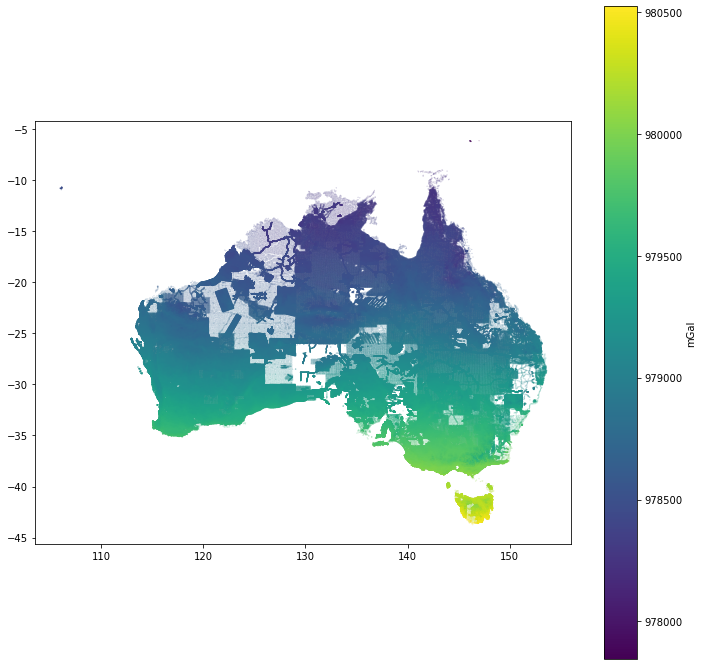

In [4]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(data.longitude, data.latitude, c=data.gravity, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Compute gravity disturbance

In [5]:
ell = bl.WGS84
disturbance = data.gravity - ell.normal_gravity(data.latitude, data.height)
data["disturbance"] = ("point", disturbance)

In [6]:
data

<xarray.Dataset>
Dimensions:            (point: 1789824)
Coordinates:
    longitude          (point) float64 140.1 140.1 140.1 ... 136.0 136.0 136.1
    latitude           (point) float64 -31.56 -31.56 -31.59 ... -33.49 -33.5
    height             (point) float32 111.654 112.496 ... 100.925 144.069
Dimensions without coordinates: point
Data variables:
    gravity            (point) float32 979409.5 979410.1 ... 979583.0 979574.9
    gravity_accuracy   (point) float32 0.049999997 0.049999997 ... 0.049999997
    height_error       (point) float32 1.0 1.0 1.0 1.0 1.0 ... 2.0 2.0 2.0 2.0
    reliability_index  (point) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    disturbance        (point) float64 -4.502 -3.588 -3.967 ... 7.314 11.59
Attributes:
    Conventions:  CF-1.8
    title:        Compilation of gravity ground surveys for Australia
    institution:  Commonwealth of Australia (Geoscience Australia)
    crs:          WGS84
    source:       Compiled from the collection by Wynne, P. 2018. NetCDF Grou...
    uuid:         d6e3c3a8-5a20-4d8b-afca-e55f754e4ce1
    license:      Creative Commons Attribution 4.0 International Licence
    references:   https://doi.org/10.26186/5c1987fa17078
    history:      2020-10-13T15:39:24+01:00 : Data with reliability index of ...

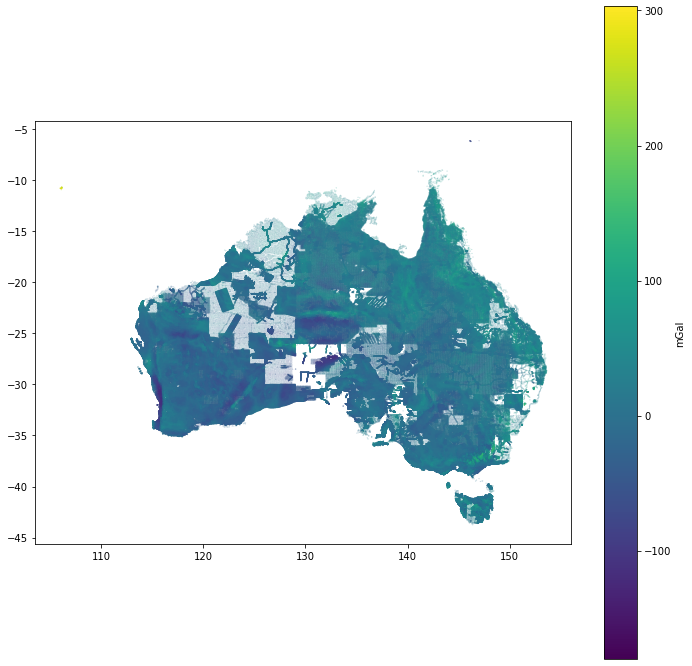

In [7]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(data.longitude, data.latitude, c=data.disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Keep only points close to the continent

In [8]:
coordinates = (data.longitude.values, data.latitude.values, data.height.values)
disturbance = data.disturbance.values

vd.get_region(coordinates)

(105.93008499999999, 153.61476, -43.735188, -6.12522)

In [9]:
inside = vd.inside(coordinates, region=(111, 154, -44, -7))
coordinates = tuple(c[inside] for c in coordinates)
disturbance = disturbance[inside]

In [10]:
vd.get_region(coordinates)

(112.934764, 153.61476, -43.735188, -9.008531999999999)

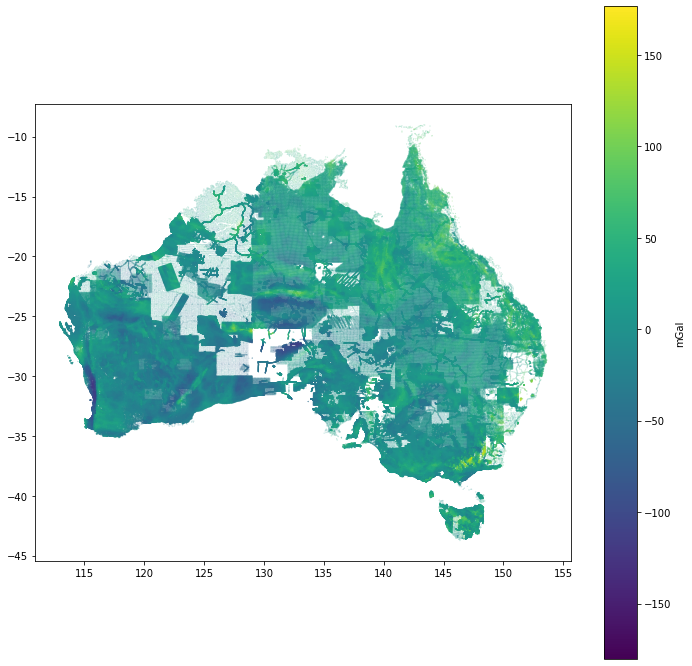

In [11]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*coordinates[:2], c=disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Project coordinates

In [12]:
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.values.mean())

easting, northing = projection(*coordinates[:2])
proj_coordinates = (easting, northing, coordinates[-1])

/home/santi/miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


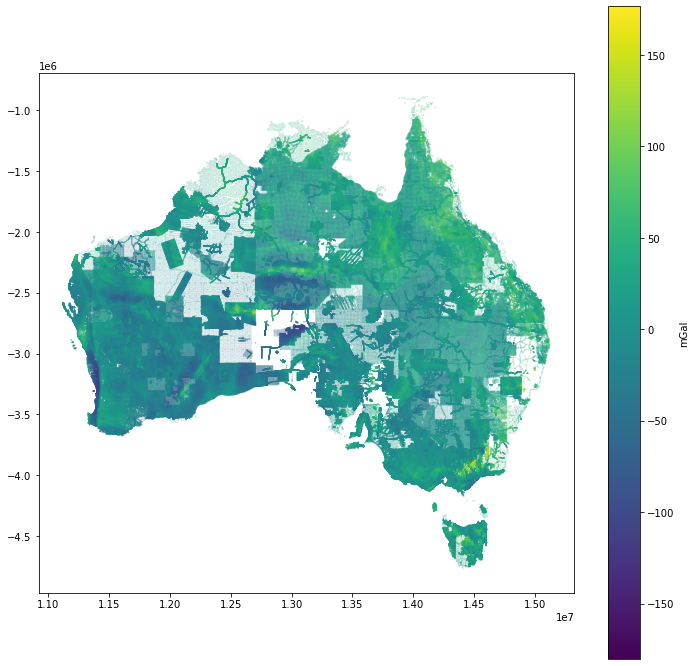

In [13]:
plt.figure(figsize=(12, 12))
tmp = plt.scatter(*proj_coordinates[:2], c=disturbance, s=0.01)
plt.gca().set_aspect("equal")
plt.colorbar(tmp, label="mGal")
plt.show()

## Grid gravity disturbance

In [14]:
depth_type = "relative_depth"
random_state = 0
block_spacing = 8e3
damping = 1e-1
depth = 2e3
window_size = 500e3

In [15]:
points = block_averaged_sources(
    proj_coordinates, depth_type=depth_type, spacing=block_spacing, depth=depth
)

In [16]:
memory_gb = proj_coordinates[0].size * points[0].size * (64 / 8) / 1024 ** 3

print("Number of data points:", proj_coordinates[0].size)
print("Number of sources:", points[0].size)
print("Memory needed to store the full Jacobian matrix: {:.2f} GB".format(memory_gb))

Number of data points: 1789755
Number of sources: 107768
Memory needed to store the full Jacobian matrix: 1437.06 GB


In [17]:
%%time
eql = EQLIterative(
    damping=damping,
    points=points,
    window_size=window_size,
    random_state=random_state,
    line_search=True,
)
eql.fit(proj_coordinates, disturbance)

CPU times: user 2h 5min 2s, sys: 14min 42s, total: 2h 19min 45s
Wall time: 21min 57s


EQLIterative(damping=0.1, line_search=True,
             points=(array([14411127.63932425, 14401839.90184096, 14412243.24296051, ...,
       14098332.11027588, 14113756.99691306, 14120484.48755517]),
                     array([-4771579.81016954, -4759639.12418224, -4758554.51837204, ...,
        -891969.58591013,  -884706.64306358,  -886852.78427801]),
                     array([-2002.224, -1834.246, -1940.713, ..., -1912.896, -1919.548,
       -1920.13 ], dtype=float32)),
             random_state=0, relative_depth=500, shuffle=True, warm_start=False,
             window_size=500000.0)

In [18]:
%%time
# Get region of longitude, latitude coordinates (in degrees)
region = vd.get_region(coordinates)
# Interpolate on a regular grid on geographic coordinates
grid = eql.grid(
    upward=data.height.values.max(),
    region=region,
    spacing=0.02,
    projection=projection,
)

/home/santi/miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 27min 33s, sys: 201 ms, total: 27min 33s
Wall time: 2min 4s


In [19]:
grid

/home/santi/miniconda3/envs/eql_source_layouts/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<xarray.Dataset>
Dimensions:   (easting: 2035, northing: 1737)
Coordinates:
  * easting   (easting) float64 112.9 113.0 113.0 113.0 ... 153.6 153.6 153.6
  * northing  (northing) float64 -43.74 -43.72 -43.7 ... -9.049 -9.029 -9.009
    upward    (northing, easting) float64 2.128e+03 2.128e+03 ... 2.128e+03
Data variables:
    scalars   (northing, easting) float64 0.1321 0.1312 0.1303 ... 12.0 11.99
Attributes:
    metadata:  Generated by EQLIterative(damping=0.1, line_search=True,\n    ...

In [20]:
grid_masked = vd.distance_mask(
    coordinates, maxdist=80e3, grid=grid, projection=projection
)

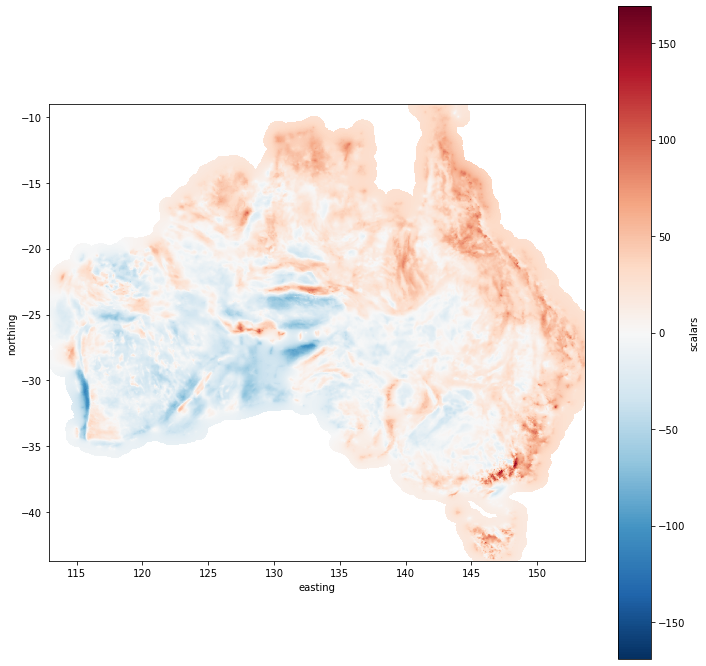

In [21]:
plt.figure(figsize=(12, 12))
grid_masked.scalars.plot()
plt.gca().set_aspect("equal")
plt.show()

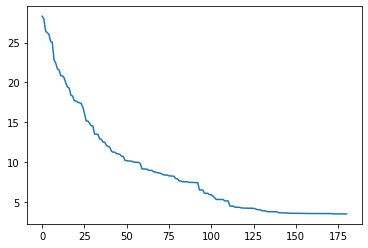

In [22]:
plt.plot(eql.errors_)
plt.show()